### Collaborative Filtering Movie Recommender 

Data Used:
* tmdb_5k
* the_movie_datasets
* movielens20m

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing
import seaborn as sns 
import matplotlib.pyplot as plt # visualization tool
import os
import pickle
import wordcloud as wc
import scipy.sparse as sparse
import xgboost as xgb
import sklearn
from scipy import stats

from surprise import Reader, Dataset, SVD, model_selection
from surprise.model_selection import cross_validate, KFold
from xgboost import XGBRegressor
from sklearn.base import BaseEstimator,TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.model_selection import KFold,train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

import warnings; warnings.simplefilter('ignore')
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
saving=False

print(os.listdir("Datasets/"))

['ml-20m', 'ml-20m.zip', 'netflix-prize-data.zip', 'the-movies-dataset', 'the-movies-dataset.zip', 'tmdb-movie-metadata', 'tmdb-movie-metadata.zip']


In [2]:
# tmdb_5k
tmdb_5000_movies=pd.read_csv("Datasets/tmdb-movie-metadata/tmdb_5000_movies.csv")
tmdb_5000_credits=pd.read_csv("Datasets/tmdb-movie-metadata/tmdb_5000_credits.csv")

# movie_datasets
data_movie = pd.read_csv('Datasets/the-movies-dataset/movies_metadata.csv')
data_rating_small = pd.read_csv('Datasets/the-movies-dataset/ratings_small.csv')
data_links_small = pd.read_csv('Datasets/the-movies-dataset/links_small.csv')

# movielens-20m
movielens_rating=pd.read_csv("Datasets/ml-20m/ratings.csv")
movielens_link=pd.read_csv("Datasets/ml-20m/links.csv")
movielens_movie=pd.read_csv("Datasets/ml-20m/movies.csv")
movielens_score=pd.read_csv("Datasets/ml-20m/genome-scores.csv")
movielens_tag=pd.read_csv("Datasets/ml-20m/genome-tags.csv")

In [3]:
tmdb_5000_credits.columns = ['id', 'title', 'cast', 'crew']
tmdb_5000 = tmdb_5000_movies.copy(deep=True)
tmdb_5000 = tmdb_5000.merge(tmdb_5000_credits, on=['id', 'title'])

In [4]:
data_movie.info()
data_links_small.info()
data_rating_small.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45466 entries, 0 to 45465
Data columns (total 24 columns):
adult                    45466 non-null object
belongs_to_collection    4494 non-null object
budget                   45466 non-null object
genres                   45466 non-null object
homepage                 7782 non-null object
id                       45466 non-null object
imdb_id                  45449 non-null object
original_language        45455 non-null object
original_title           45466 non-null object
overview                 44512 non-null object
popularity               45461 non-null object
poster_path              45080 non-null object
production_companies     45463 non-null object
production_countries     45463 non-null object
release_date             45379 non-null object
revenue                  45460 non-null float64
runtime                  45203 non-null float64
spoken_languages         45460 non-null object
status                   45379 non-null objec

In [5]:
data_links_small = data_links_small.merge(data_rating_small, on='movieId')
data_links_small.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100004 entries, 0 to 100003
Data columns (total 6 columns):
movieId      100004 non-null int64
imdbId       100004 non-null int64
tmdbId       99933 non-null float64
userId       100004 non-null int64
rating       100004 non-null float64
timestamp    100004 non-null int64
dtypes: float64(2), int64(4)
memory usage: 5.3 MB


In [6]:
data_links_small.rename(columns={'movieId':'id'}, inplace=True)

In [7]:
tmdb_5000 = tmdb_5000.merge(data_links_small, on='id')

In [8]:
movielens_dict={v:k for k,v in movielens_link.movieId.to_dict().items()}
movielens_rating.movieId=movielens_rating.movieId.apply(movielens_dict.get)
movielens_rating.userId-=1
movielens_score.movieId=movielens_score.movieId.apply(movielens_dict.get)
movielens_score.tagId-=1
movielens_tag.tagId-=1

In [9]:
tmdb_5000.dropna(subset=["release_date"], inplace=True)
tmdb_5000.replace(0, np.nan, inplace=True)

In [10]:
tmdb_5000.columns

Index(['budget', 'genres', 'homepage', 'id', 'keywords', 'original_language',
       'original_title', 'overview', 'popularity', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'vote_average',
       'vote_count', 'cast', 'crew', 'imdbId', 'tmdbId', 'userId', 'rating',
       'timestamp'],
      dtype='object')

### TMDB_5k
what should i do ? huh ?

In [11]:
np.sum(tmdb_5000.isnull())

budget                   1304
genres                      0
homepage                11325
id                          0
keywords                    0
original_language           0
original_title              0
overview                    0
popularity                  0
production_companies        0
production_countries        0
release_date                0
revenue                  1702
runtime                     7
spoken_languages            0
status                      0
tagline                  1553
title                       0
vote_average                0
vote_count                  0
cast                        0
crew                        0
imdbId                      0
tmdbId                      1
userId                      0
rating                      0
timestamp                   0
dtype: int64

In [156]:
rating_count = pd.DataFrame(tmdb_5000.groupby(tmdb_5000['userId'])[['rating']].count()).reset_index()

In [162]:
(rating_count['rating'].max(),rating_count['rating'].min())

(396, 1)

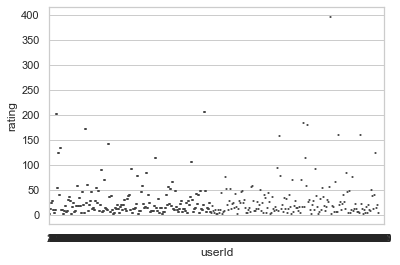

In [163]:
sns.boxplot(x='userId', y="rating", data=rating_count)
plt.show()

In [189]:
x, y = rating_count['userId'][:100], rating_count['rating']


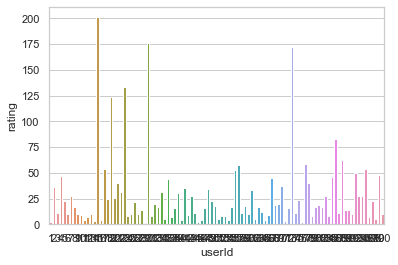

In [190]:
sns.set(style="whitegrid")
ax = sns.barplot(x,y)

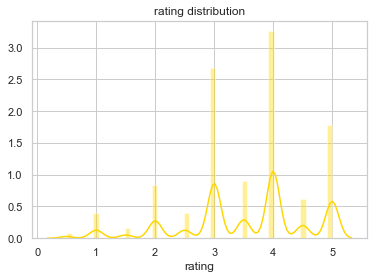

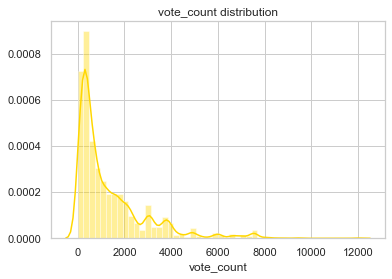

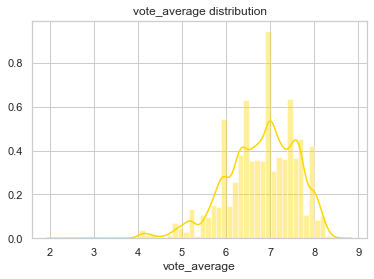

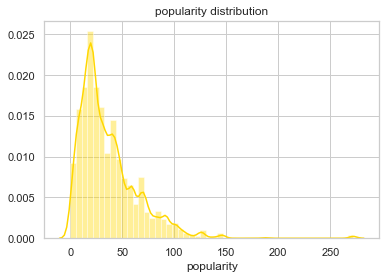

In [198]:
sns.set_color_codes()
def distdata(feat, title):
    sns.distplot(tmdb_5000[feat], color='gold')
    plt.title(title)
    plt.show()
    
for attr in ['rating', 'vote_count', 'vote_average', 'popularity']:
    distdata(attr, attr + ' distribution')

### Exploratory Data Analysis (EDA) Part 2
what should i do ? huh ?

In [14]:
# helper functions to deal with multi-hot features
def group_indices(series,index="id"):
    d={}
    for i in range(series.size):
        l=eval(series.iloc[i])
        for x in l:
            d.setdefault(x[index],[])
            d[x[index]].append(i)
    return d

def get_groups(series,index="name"):
    s=set()
    for i in range(series.size):
        l=eval(series.iloc[i])
        for x in l:s.add(x[index])
    return list(s)

def multi_count(series,index="id"):
    return {k:len(v) for (k,v) in group_indices(series,index).items()}

def expand_multi_feature(df,column,index="id"):
    groups=group_indices(df[column],index=index)
    result=pd.DataFrame()
    for name,indices in groups.items():
        rows=df.iloc[indices].copy()
        rows[column]=name
        result=result.append(rows)
    return result

def multi_groupby(df,column,index="id"):
    return expand_multi_feature(df,column,index).groupby(column)

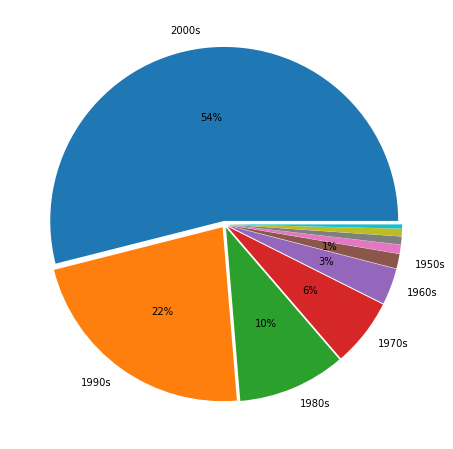

In [15]:
# numbers of movies released in each decade
def count_pie(series,filename):
    counts=series.value_counts()
    counts=counts/counts.sum()
    labels=['' if num<0.01 else str(year) for (year,num) in counts.items()]
    f, ax = plt.subplots(figsize=(8, 8))
    explode = [0.02 if counts.iloc[i] < 100 else 0.001 for i in range(counts.size)]
    plt.pie(counts,labels=labels,autopct=lambda x:'{:1.0f}%'.format(x) if x > 1 else '',explode=explode)
    if saving:plt.savefig(filename,dpi=150)
    plt.show()

def count_decade_pie(df,filename):
    count_pie(df.release_date.dropna().apply(lambda x:str(int(x[:4])//10*10)+'s'),filename)
    
count_decade_pie(tmdb_5000,filename="pie_decade.png")

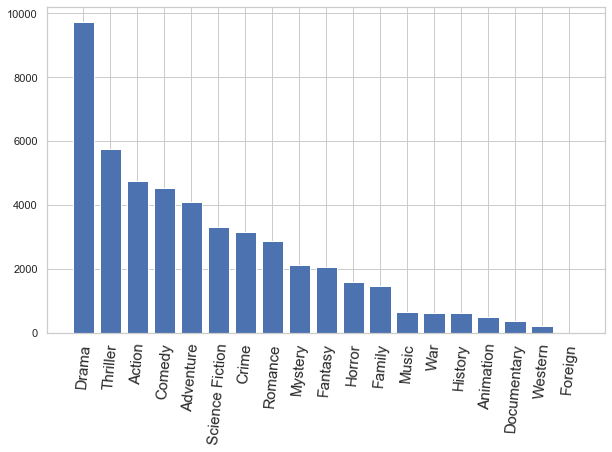

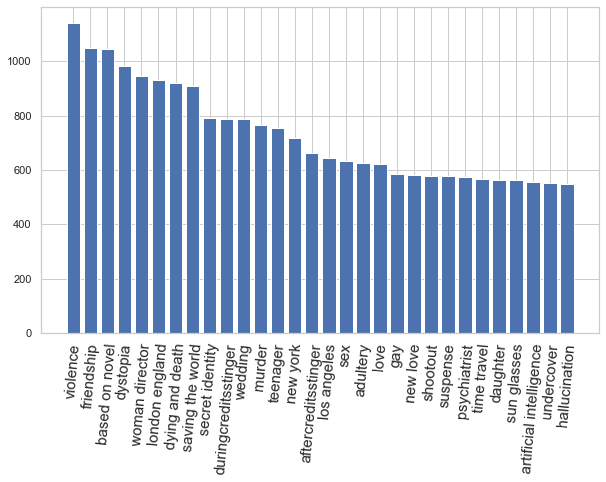

In [16]:
# numbers of movies of different genres and keywords
def multi_bar(series,filename):    
    sns.set(style="whitegrid")
    count=multi_count(series,"name")
    count=sorted(count.items(),key=lambda x:x[1],reverse=True)
    count=dict(count[:30])
    f, ax = plt.subplots(figsize=(10, 6))
    plt.xticks(rotation=85, fontsize=15)
    plt.bar(count.keys(),count.values(),align="center")
#     plt.pie(count.values(),labels=count.keys())
    if saving:plt.savefig(filename,bbox_inches="tight",dpi=100)
    plt.show()

multi_bar(tmdb_5000.genres,filename="bar_genres.png")
multi_bar(tmdb_5000.keywords,filename="bar_keywords.png")

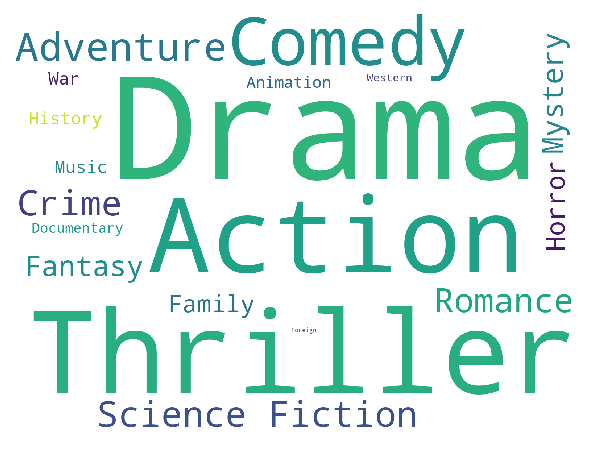

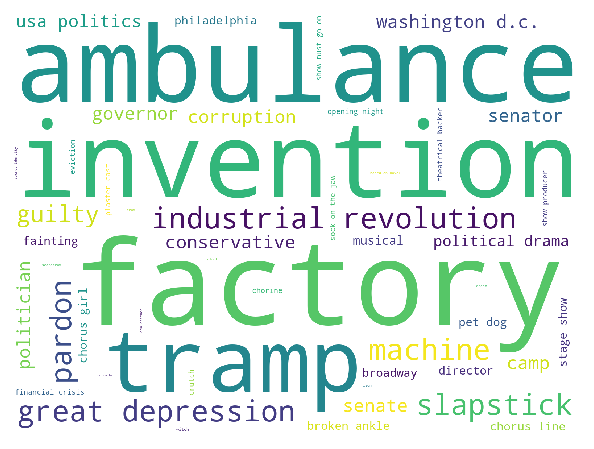

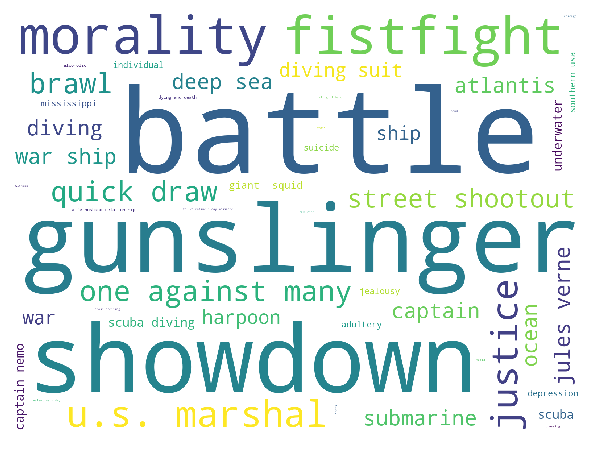

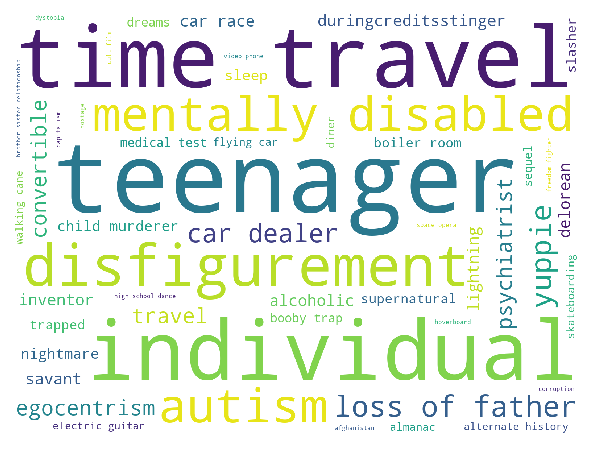

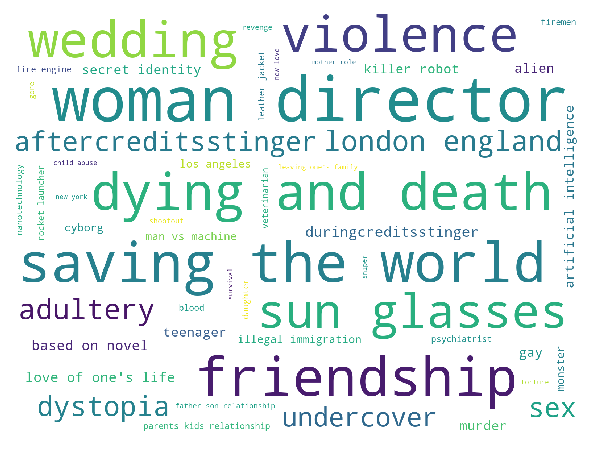

In [17]:
# wordcloud of genres and keywords
def multi_wordcloud(series,filename):
    w=wc.WordCloud(background_color="white",margin=20,width=800,height=600,prefer_horizontal=0.7,max_words=50,scale=2)
    count=multi_count(series,"name")
    w.generate_from_frequencies(count)
    if saving:w.to_file(filename)
    f, ax = plt.subplots(figsize=(16, 8))
    plt.axis('off')
    plt.imshow(w)
    plt.show()

multi_wordcloud(tmdb_5000.genres,filename="wordcloud_genres.png")
multi_wordcloud(tmdb_5000.keywords[tmdb_5000.release_date.apply(lambda x:int(x[:4])//10*10)==1930],filename="wordcloud_keywords_1930.png")
multi_wordcloud(tmdb_5000.keywords[tmdb_5000.release_date.apply(lambda x:int(x[:4])//10*10)==1950],filename="wordcloud_keywords_1950.png")
multi_wordcloud(tmdb_5000.keywords[tmdb_5000.release_date.apply(lambda x:int(x[:4])//10*10)==1980],filename="wordcloud_keywords_1980.png")
multi_wordcloud(tmdb_5000.keywords[tmdb_5000.release_date.apply(lambda x:int(x[:4])//10*10)==2000],filename="wordcloud_keywords_2000.png")

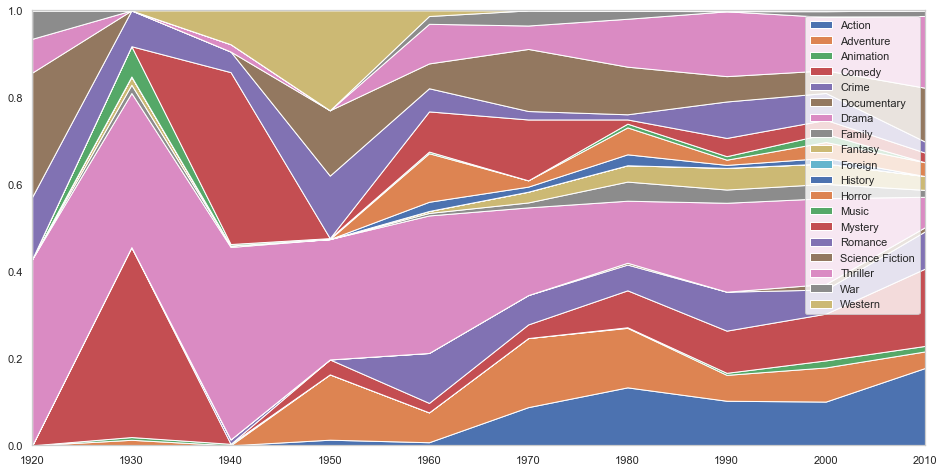

In [18]:
# change of percentage of movies of each genres released in each decade
def multi_stackplot_10year(df,value,filename):
    sns.set(style="whitegrid")
    df=df[["release_date",value]].dropna()
    df.release_date=df.release_date.apply(lambda x:int(x[:4])//10*10)
    df=df.sort_values("release_date")
    years=pd.Series(range(df["release_date"].min(),df["release_date"].max()+1,10),name="year")
    counts=[]
    groups=[]
    for (name,col) in multi_groupby(df,"genres","name"):
        groups.append(name)
        counts.append(pd.merge(years.to_frame(),col.groupby("release_date").size().rename("count").to_frame(),
                               how="left",left_on="year",right_on="release_date").fillna(0).astype(int)["count"])
    counts=np.array(counts)
    counts=counts.transpose(0,1)
    counts=counts/counts.sum(0)
    f, ax = plt.subplots(figsize=(16, 8))
    plt.stackplot(years,counts,labels=groups)
    plt.xticks(years)
    plt.xlim(years.iloc[0],years.iloc[-1])
    plt.ylim(0,1)
    plt.legend()
    if saving:plt.savefig(filename,dpi=200)
    plt.show()

multi_stackplot_10year(tmdb_5000,"genres",filename="stackplot_genres.png")

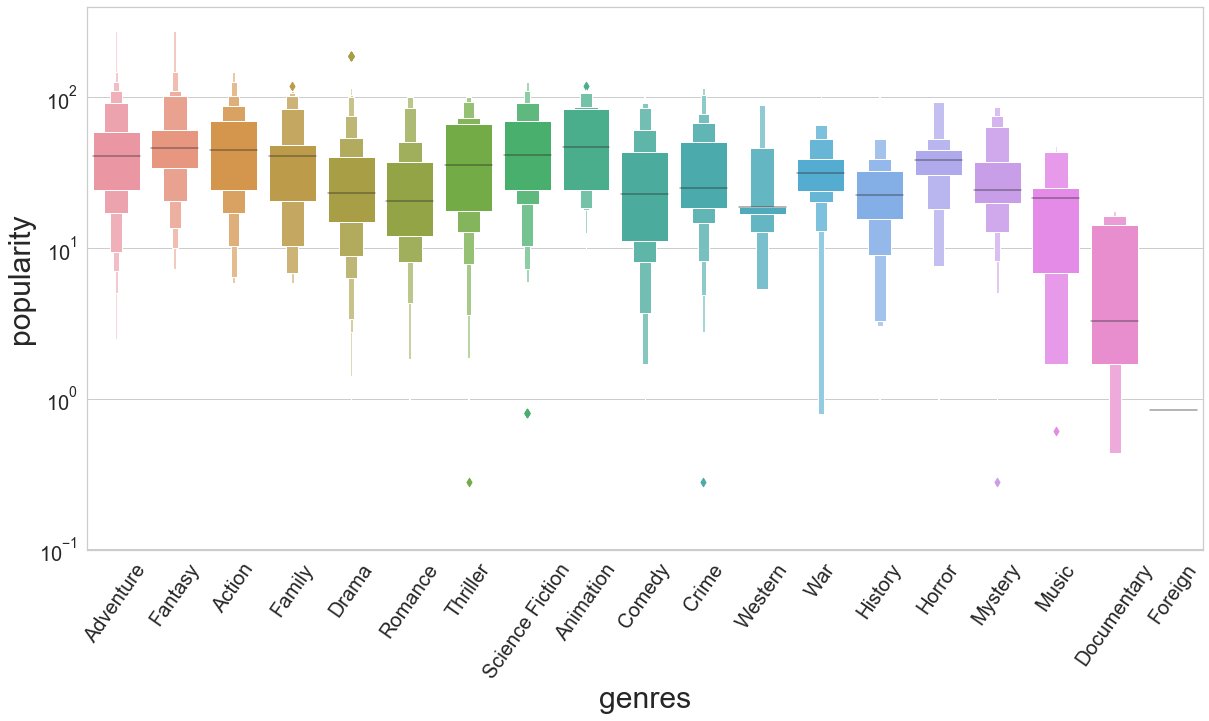

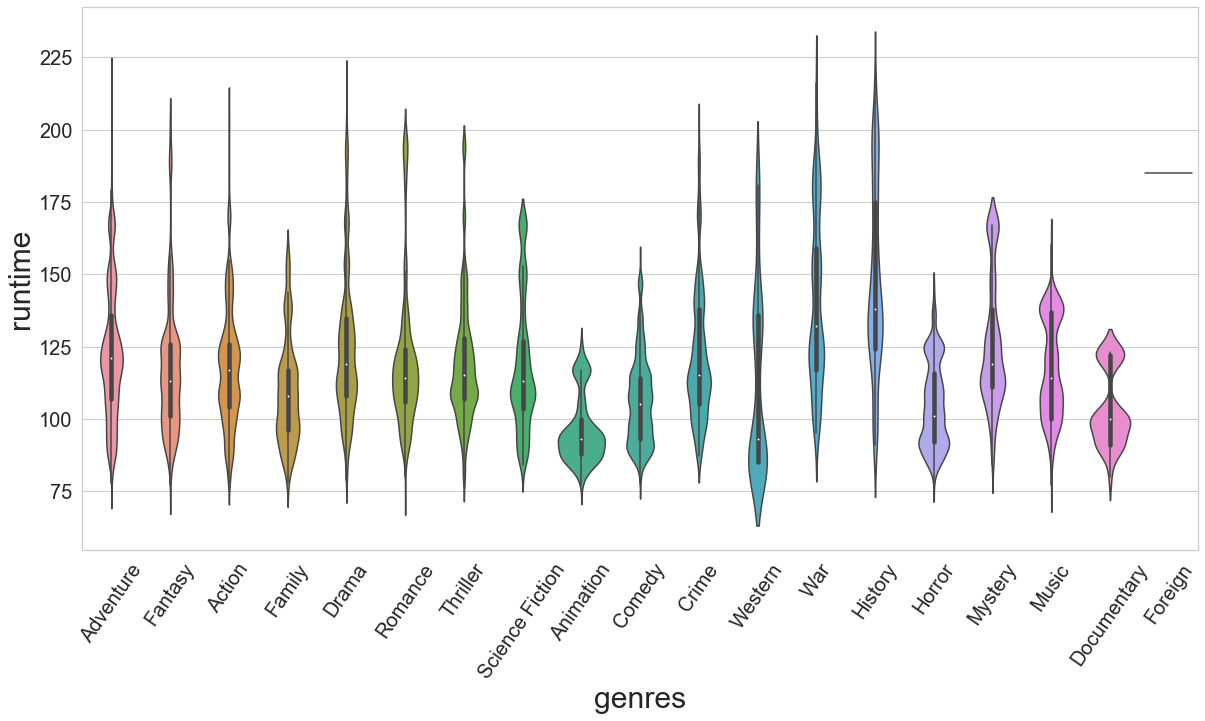

In [19]:
# distribution of popularity and runtime groupby genres
def plotby_box(df,x,y,filename,yscale="linear"):
    sns.set(style="whitegrid")
    df=df.replace(0,np.nan).copy()
    f,ax=plt.subplots(figsize=(20, 10))
    sns.boxenplot(data=expand_multi_feature(df,x,"name"),x=x,y=y)
    plt.yscale(yscale)
    plt.yticks(fontsize=20)
    plt.xticks(rotation=55,fontsize=20)
    plt.xlabel(x,fontsize=30)
    plt.ylabel(y,fontsize=30)
    if saving:plt.savefig(filename,bbox_inches="tight",dpi=150)
    plt.show()
    
def plotby_violin(df,x,y,filename,yscale="linear"):
    sns.set(style="whitegrid")
    df=df.replace(0,np.nan).copy()
    f,ax=plt.subplots(figsize=(20, 10))
    sns.violinplot(data=expand_multi_feature(df,x,"name"),x=x,y=y)
    plt.yscale(yscale)
    plt.yticks(fontsize=20)
    plt.xticks(rotation=55,fontsize=20)
    plt.xlabel(x,fontsize=30)
    plt.ylabel(y,fontsize=30)
    if saving:plt.savefig(filename,bbox_inches="tight",dpi=150)
    plt.show()
    
plotby_box(tmdb_5000,"genres","popularity",yscale="log",filename="genres_popularity.png")
plotby_violin(tmdb_5000,"genres","runtime",yscale="linear",filename="genres_runtime.png")

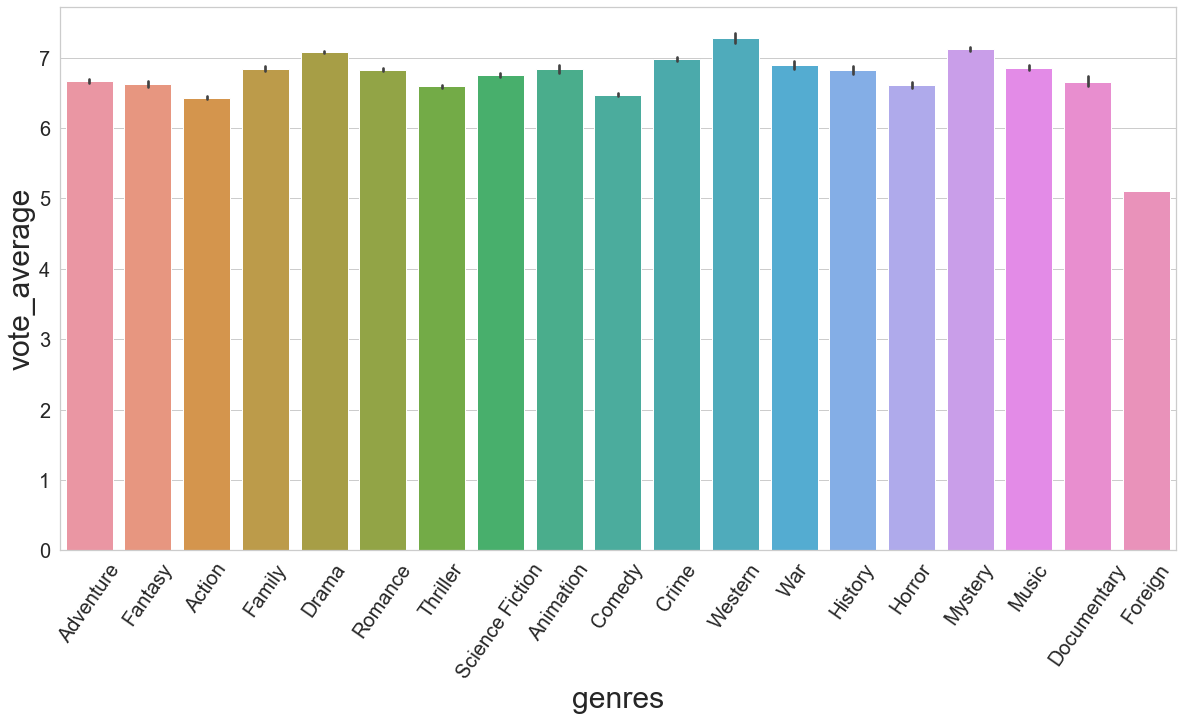

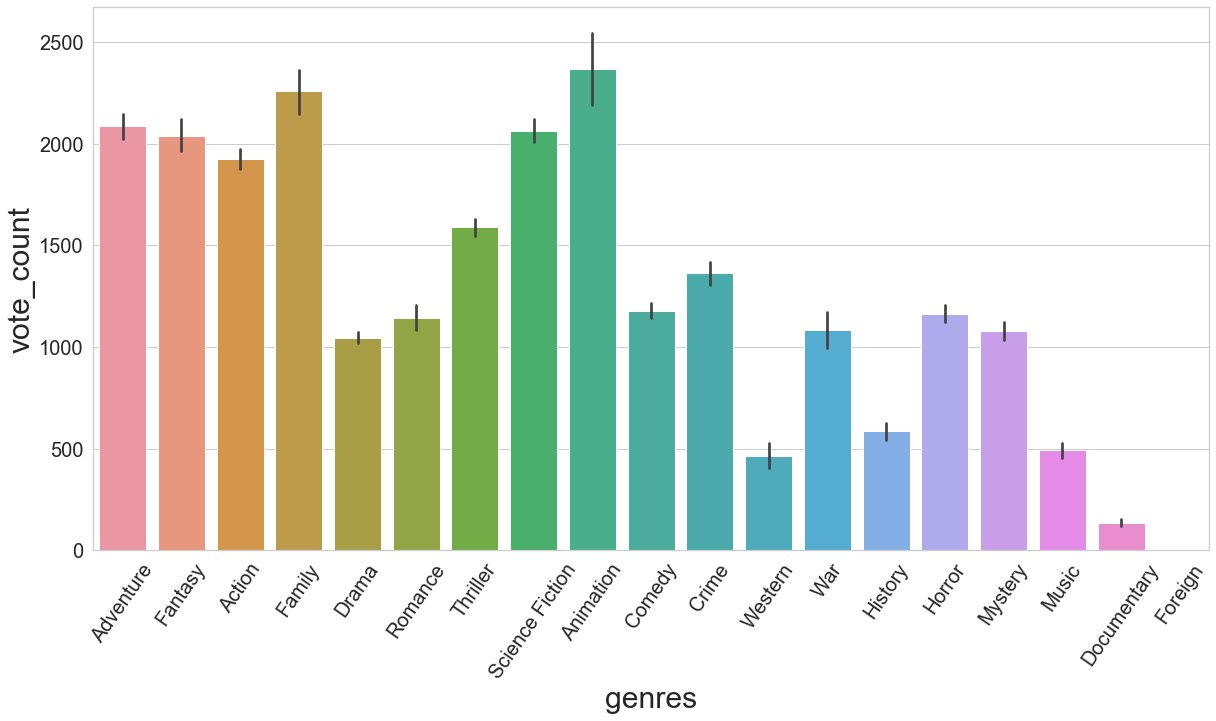

In [20]:
# average vote of each genres' movies
def plotby_bar(df,x,y,filename):
    sns.set(style="whitegrid")
    df=df.replace(0,np.nan).copy()
    f,ax=plt.subplots(figsize=(20, 10))
    sns.barplot(data=expand_multi_feature(df,x,"name"),x=x,y=y)
    plt.yticks(fontsize=20)
    plt.xticks(rotation=55,fontsize=20)
    plt.xlabel(x,fontsize=30)
    plt.ylabel(y,fontsize=30)
    if saving:plt.savefig(filename,bbox_inches="tight",dpi=150)
    plt.show()
    
plotby_bar(tmdb_5000,"genres","vote_average",filename="genres_vote_average.png")
plotby_bar(tmdb_5000,"genres","vote_count",filename="genres_vote_count.png")

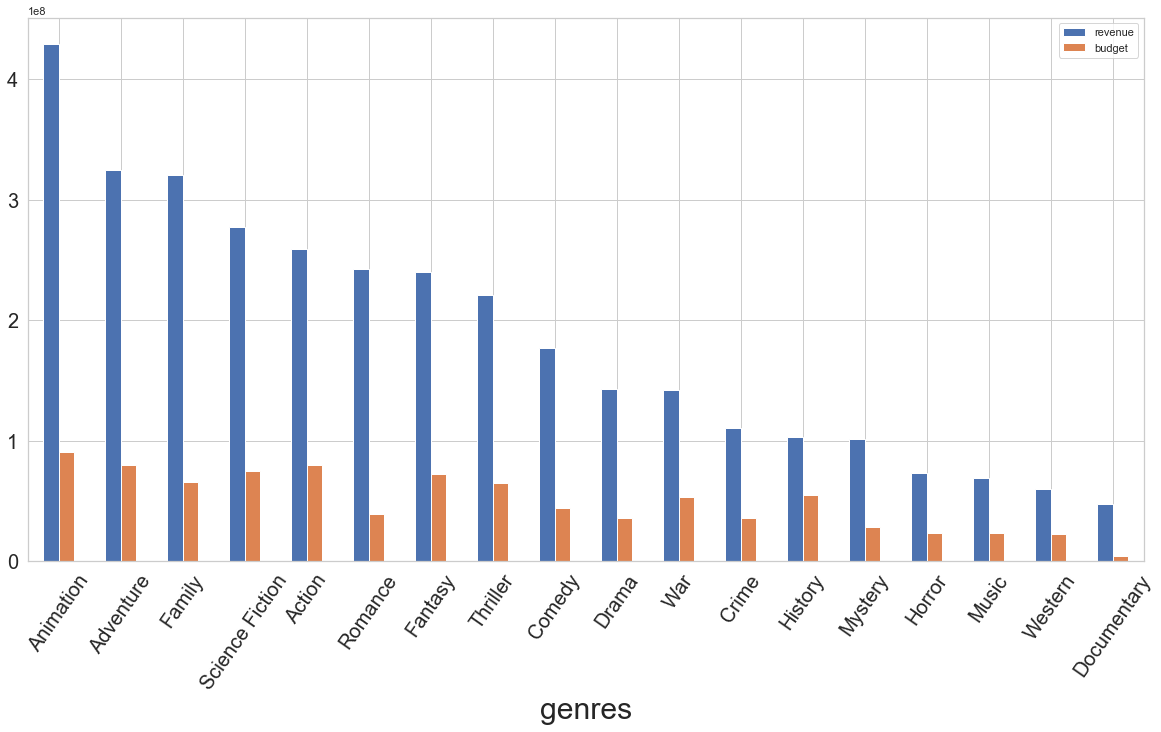

In [21]:
# average budget and revenue of each genres' movies
def plotby_2bar(df,x,y,filename):
    sns.set(style="whitegrid")
    df=df.replace(0,np.nan).copy()
    f,ax=plt.subplots(figsize=(20, 10))
    multi_groupby(df.dropna(subset=y),x,"name")[y].mean().sort_values(y,ascending=False).plot(kind="bar",ax=ax)
    plt.yticks(fontsize=20)
    plt.xticks(rotation=55,fontsize=20)
    plt.xlabel(x,fontsize=30)
    if saving:plt.savefig(filename,bbox_inches="tight",dpi=150)
    plt.show()

plotby_2bar(tmdb_5000,"genres",["revenue","budget"],filename="genres_budget_revenue.png")

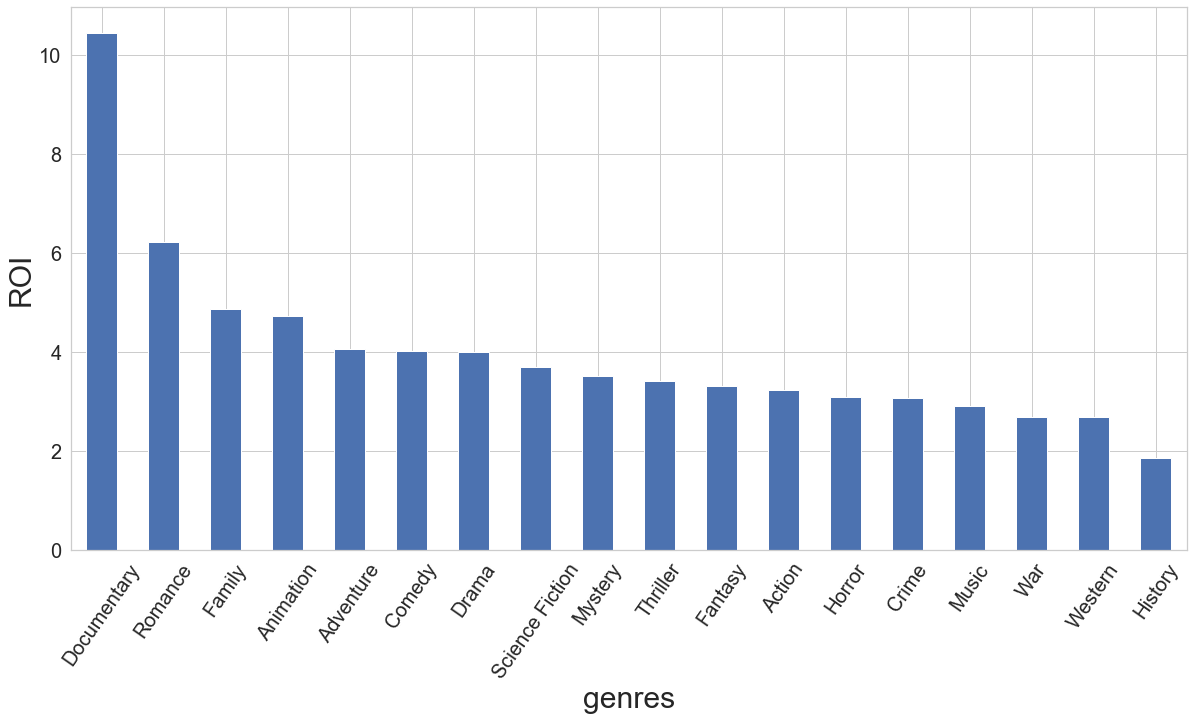

In [22]:
# return on investment of each genres' movies
def plotby_portion(df,x,y,filename):
    sns.set(style="whitegrid")
    df=df.replace(0,np.nan).copy()
    f,ax=plt.subplots(figsize=(20, 10))
#     sns.barplot(data=multi_groupby(df,x,"name")[y].mean().transpose())
    group=multi_groupby(df.dropna(subset=y),x,"name")
    (group[y[0]].mean()/group[y[1]].mean()).sort_values(ascending=False).plot(kind="bar")
    plt.yticks(fontsize=20)
    plt.xticks(rotation=55,fontsize=20)
    plt.xlabel(x,fontsize=30)
    plt.ylabel("ROI",fontsize=30)
    if saving:plt.savefig(filename,bbox_inches="tight",dpi=150)
    plt.show()
    
plotby_portion(tmdb_5000,"genres",["revenue","budget"],filename="genres_ROI.png")

# Singular Value Decomposition

One way to handle the scalability and sparsity issue created by CF is to leverage a latent factor model to capture the similarity between users and items. Essentially, we want to turn the recommendation problem into an optimization problem. We can view it as how good we are in predicting the rating for items given a user. One common metric is Root Mean Square Error (RMSE). The lower the RMSE, the better the performance.

Now talking about latent factor you might be wondering what is it ?It is a broad idea which describes a property or concept that a user or an item have. For instance, for music, latent factor can refer to the genre that the music belongs to. SVD decreases the dimension of the utility matrix by extracting its latent factors. Essentially, we map each user and each item into a latent space with dimension r. Therefore, it helps us better understand the relationship between users and items as they become directly comparable. 

## SVD for TMDB_5K

I still dunno how diz works -\\(-_-)/-

In [23]:
reader = Reader()
data = Dataset.load_from_df(tmdb_5000[['userId', 'id', 'rating']], reader)
algo = SVD()
cross_validate(algo, data, measures=['RMSE', 'MAE', 'MSE'], cv=5, verbose=True)

Evaluating RMSE, MAE, MSE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9371  0.8868  0.9097  0.9104  0.8797  0.9048  0.0203  
MAE (testset)     0.7184  0.6897  0.7073  0.7028  0.6828  0.7002  0.0127  
MSE (testset)     0.8781  0.7864  0.8276  0.8289  0.7739  0.8190  0.0368  
Fit time          0.93    0.92    0.90    0.93    0.92    0.92    0.01    
Test time         0.02    0.03    0.03    0.02    0.02    0.02    0.00    


{'test_rmse': array([0.93708818, 0.8868006 , 0.90973734, 0.91043781, 0.87973197]),
 'test_mae': array([0.71842916, 0.68970764, 0.70730894, 0.70281995, 0.68277119]),
 'test_mse': array([0.87813425, 0.78641531, 0.82762203, 0.828897  , 0.77392833]),
 'fit_time': (0.9280731678009033,
  0.9220561981201172,
  0.8969757556915283,
  0.9300808906555176,
  0.9240591526031494),
 'test_time': (0.024079561233520508,
  0.025083541870117188,
  0.025585412979125977,
  0.02207350730895996,
  0.021070480346679688)}

In [24]:
trainset = data.build_full_trainset()
algo.fit(trainset)

In [25]:
algo.predict(1, 302, 3)

Prediction(uid=1, iid=302, r_ui=3, est=3.5449897406801503, details={'was_impossible': False})

# CF Recommendation using TMDB_5k Datasets

diz is how u do it i guez ?

In [26]:
pred = pd.DataFrame(tmdb_5000[['userId','id','rating']])
pred.head()

,userId,id,rating
0,39,285,4.0
1,492,559,5.0
2,30,767,4.0
3,19,58,3.0
4,23,58,3.5


In [27]:
def check_system(Id,movieId,limit,df=pred,userId='userId',algo=algo):
    user_df = df[df['userId'] == Id]
    rated_movs = user_df['id'].tolist()
    #est_list = []
    
    #for i in range(0,len(rated_movs)):
    #    a = round(algo.predict(userId,rated_movs[i]).est,2)
    #    est_list.append(a)
    
    #user_df['est'] = est_list
    user_df['est'] = user_df['id'].apply(lambda x: round(algo.predict(Id,x).est,2))
    user_df['error'] = user_df['est']-user_df['rating']
    user_df['avg_error'] = user_df['error'].mean()
    
    if limit == None:
        return user_df
    
    else:
        return user_df.head(limit)

### Error measurement on rating predictions

In [28]:
# userId : 39
check_system(39, 'id', 10)

,userId,id,rating,est,error,avg_error
0,39,285,4.0,3.79,-0.21,-0.019
406,39,296,5.0,4.40,-0.60,-0.019
1512,39,22,4.0,3.73,-0.27,-0.019
2128,39,180,5.0,3.78,-1.22,-0.019
3224,39,330,2.0,3.04,1.04,-0.019
3348,39,332,3.0,3.56,0.56,-0.019
5423,39,231,4.0,3.61,-0.39,-0.019
5595,39,588,3.0,3.80,0.80,-0.019
6084,39,593,3.0,4.33,1.33,-0.019
6917,39,165,5.0,3.96,-1.04,-0.019


In [29]:
# userId : 492
check_system(492, 'id', 10)

,userId,id,rating,est,error,avg_error
1,492,559,5.0,3.90,-1.10,-0.002353
1126,492,608,3.0,3.93,0.93,-0.002353
3640,492,35,4.0,3.57,-0.43,-0.002353
5209,492,824,4.0,3.49,-0.51,-0.002353
5816,492,306,5.0,4.25,-0.75,-0.002353
6446,492,199,3.0,3.46,0.46,-0.002353
6668,492,1369,3.0,3.24,0.24,-0.002353
6731,492,509,3.0,3.72,0.72,-0.002353
7307,492,820,5.0,3.82,-1.18,-0.002353
8757,492,326,3.0,3.62,0.62,-0.002353


In [30]:
# userId : 100
check_system(100, 'id', 10)

,userId,id,rating,est,error,avg_error
893,100,95,3.0,3.09,0.09,0.006
1001,100,608,4.0,4.38,0.38,0.006
3546,100,25,4.0,3.64,-0.36,0.006
4599,100,786,3.0,3.10,0.10,0.006
5108,100,802,4.0,3.46,-0.54,0.006
6834,100,745,4.0,4.16,0.16,0.006
7350,100,708,3.0,3.21,0.21,0.006
11423,100,1073,5.0,4.07,-0.93,0.006
14107,100,62,3.0,3.56,0.56,0.006
15570,100,141,3.0,3.39,0.39,0.006


# Recommendation

Item Based Collaborative Filtering using sparse matrix

In [31]:
# define transformers
class SparseMatrixTransformer(BaseEstimator,TransformerMixin):
    def __init__(self,row=None,col=None,value=None,shape=None):
        self.row=row
        self.col=col
        self.value=value
        self.shape=shape
    
    def fit(self,X,y=None):
        self.shape=(X[self.row].max()+1,X[self.col].max()+1)
        return self
    
    def transform(self,X,y=None):
        if type(X) is pd.DataFrame:
            return sparse.csr_matrix(sparse.coo_matrix((X[self.value],(X[self.row],X[self.col])),self.shape))
        else:
            return sparse.csr_matrix(sparse.coo_matrix((X[:,2],(X[:,0],X[:,1])),self.shape))
    
user_movie_transformer=SparseMatrixTransformer(row="userId",col="movieId",value="rating").fit(movielens_rating)
movie_tag_transformer=SparseMatrixTransformer(row="movieId",col="tagId",value="relevance",shape=(user_movie_transformer.shape[1],movielens_tag.tagId.max()+1))

In [32]:
# base class for recommendation system
class RecommenderMixin(BaseEstimator,TransformerMixin):
    def __init__(self,n_rec=10):
        self.n_rec=n_rec
    
    def evaluate(self,X_train,X_valid,silent=False):
        n_users,n_items=X_train.shape
        X=(X_train+X_valid).T
        item_rating=np.array([row.data.mean() if row.nnz else 0 for row in X])
        item_rating[np.isnan(item_rating)]
        mean_rating=X.data.mean()
        if not silent:print("predicting...")
        recommend=self.predict(X_train)
        if not silent:print("evaluating...")
        intersect=np.asarray(X_valid[np.arange(n_users).repeat(self.n_rec),recommend.flatten()].reshape(n_users,-1))
        hit=(intersect!=0).sum()
        precision=hit/recommend.size
        recall=hit/X_valid.nnz
        coverage=np.unique(recommend).size/n_items
        hit_rating=(intersect[intersect!=0]).mean()
        indices=recommend[(intersect!=0)]
        recom_rating=np.average(item_rating[indices])
        print("accuracy=%.4f"%precision)
        print("recall=%.4f"%recall)
        print("cover=%.4f"%coverage)
        print("user's vote to the hit movies=%.4f"%(hit_rating))
        print("average vote to the hit movies=%.4f"%(recom_rating))
        print("average vote to all movies=%.4f"%(mean_rating))
        
    def fit_predict(self,X,y=None):
        return self.fit(X,y).predict(X)

In [33]:
# item based colaborative filtering
# calculating the similarity between movies based on users' vote to the movies
class ItemBasedCF(RecommenderMixin):
    def __init__(self,n_rec=10,n_sim=20,file_name=None,baseline=3.0):
        super().__init__(n_rec=n_rec)
        self.baseline=baseline
        if file_name:
            self.similar_matrix=sparse.load_npz(file_name)
            self.n_sim=self.similar_matrix.shape[1]
        else:
            self.n_sim=n_sim
            self.similar_matrix=None
        
    def save(self,file_name):
        sparse.save_npz(file_name,self.similar_matrix)

    def fit(self,X,y=None,silent=False):
        if not silent:print("calculating the similar matrix...")
        n_users,n_items=X.shape
        user_movie=X.copy()
        user_movie.data-=self.baseline
        norms=sparse.linalg.norm(user_movie,axis=0)
        norms[norms==0]=1
        user_movie*=sparse.diags(1/norms)
        movie_sim_matrix=user_movie.T*user_movie
        if not silent:print("sparsifying similar matrix...")
        row=np.arange(n_items).repeat(self.n_sim)
        col=np.array([np.argpartition(row.toarray().flatten(),-self.n_sim)[-self.n_sim:].copy() for row in movie_sim_matrix]).flatten()
        self.similar_matrix=sparse.csr_matrix(sparse.coo_matrix((np.asarray(movie_sim_matrix[row,col]).flatten(),(row,col)),(n_items,n_items)))
        if not silent:print("fitting done.")
        return self
    
    def transform(self,X,y=None):
        user_movie=X.copy()
        user_movie.data-=self.baseline
        return user_movie*self.similar_matrix
    
    def predict(self,X):
        watched_movies=X.copy()
        watched_movies.data.fill(np.inf)
        movie_favor=self.transform(X)-watched_movies
        return np.array([np.argpartition(row.toarray().flatten(),-self.n_rec)[-self.n_rec:].copy() for row in movie_favor])
    
# itemCF=ItemBasedCF(file_name="ItemBasedCF.npz")

In [34]:
# fitting item based colaborative filtering
itemCF=ItemBasedCF()
%time itemCF.fit(user_movie_transformer.transform(movielens_rating))
if saving:itemCF.save("ItemBasedCF.npz")

calculating the similar matrix...
sparsifying similar matrix...
fitting done.
Wall time: 51.9 s


In [35]:
movielens_movie.iloc[17506]

movieId                                        88140
title      Captain America: The First Avenger (2011)
genres          Action|Adventure|Sci-Fi|Thriller|War
Name: 17506, dtype: object

In [36]:
# example of the most similar movies to a specified movie
def movie_similar(rs,movie):
    index=rs.similar_matrix[movie].indices
    return pd.merge(movielens_movie.iloc[index].reset_index(drop=True),pd.DataFrame({"similar":rs.similar_matrix[movie,index].toarray().flatten()}),left_index=True,right_index=True).sort_values("similar",ascending=False).reset_index(drop=True)
    
movie_similar(itemCF,17506)

,movieId,title,genres,similar
0,88140,Captain America: The First Avenger (2011),Action|Adventure|Sci-Fi|Thriller|War,1.000000
1,86332,Thor (2011),Action|Adventure|Drama|Fantasy|IMAX,0.482128
2,89745,"Avengers, The (2012)",Action|Adventure|Sci-Fi|IMAX,0.413647
3,77561,Iron Man 2 (2010),Action|Adventure|Sci-Fi|Thriller|IMAX,0.401208
4,87232,X-Men: First Class (2011),Action|Adventure|Sci-Fi|Thriller|War,0.390539
5,102125,Iron Man 3 (2013),Action|Sci-Fi|Thriller|IMAX,0.354732
6,95510,"Amazing Spider-Man, The (2012)",Action|Adventure|Sci-Fi|IMAX,0.331462
7,91542,Sherlock Holmes: A Game of Shadows (2011),Action|Adventure|Comedy|Crime|Mystery|Thriller,0.323050
8,110102,Captain America: The Winter Soldier (2014),Action|Adventure|Sci-Fi|IMAX,0.321387
9,106072,Thor: The Dark World (2013),Action|Adventure|Fantasy|IMAX,0.298413


In [37]:
movielens_rating[movielens_rating.userId == 5]

,userId,movieId,rating,timestamp
517,5,0,5.0,858275452
518,5,2,3.0,858275558
519,5,6,5.0,858275558
520,5,16,5.0,858275452
521,5,51,5.0,858275658
522,5,61,5.0,858275452
523,5,133,3.0,858275783
524,5,138,4.0,858275917
525,5,139,5.0,858275452
526,5,257,4.0,858275658


In [38]:
# see the already watched movies of a specified movie
def user_watched(user):
    watched_movies=movielens_rating[movielens_rating.userId==user]
    return pd.DataFrame({"title":movielens_movie.title.iloc[watched_movies.movieId],"genres":movielens_movie.genres.iloc[watched_movies.movieId],"rating":watched_movies.rating.values})

user_watched(5)

,title,genres,rating
0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5.0
2,Grumpier Old Men (1995),Comedy|Romance,3.0
6,Sabrina (1995),Comedy|Romance,5.0
16,Sense and Sensibility (1995),Drama|Romance,5.0
51,Mighty Aphrodite (1995),Comedy|Drama|Romance,5.0
61,Mr. Holland's Opus (1995),Drama,5.0
133,Down Periscope (1996),Comedy,3.0
138,Up Close and Personal (1996),Drama|Romance,4.0
139,"Birdcage, The (1996)",Comedy,5.0
257,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi,4.0


In [39]:
# evaluating and comparing the recommendation system
rating_train,rating_valid=train_test_split(movielens_rating[["userId","movieId","rating"]])
rating_train=user_movie_transformer.transform(rating_train)
rating_valid=user_movie_transformer.transform(rating_valid)
%time ItemBasedCF().fit(rating_train).evaluate(rating_train,rating_valid)

calculating the similar matrix...
sparsifying similar matrix...
fitting done.
predicting...
evaluating...
accuracy=0.2700
recall=0.0748
cover=0.1873
user's vote to the hit movies=4.2950
average vote to the hit movies=4.0475
average vote to all movies=3.5255
Wall time: 1min 1s


# Prediction

Predicting average vote of the movies

In [40]:
pred = tmdb_5000.dropna(subset=["vote_count"]).copy()
pred["release_year"] = pred.release_date.apply(lambda x:int(x[:4]))
pred = pred[pred.vote_count>=100].copy()

In [41]:
# check multi-hot features
pd.DataFrame({
    "cast":pd.Series(multi_count(tmdb_5000.cast)).describe(),
    "crew":pd.Series(multi_count(tmdb_5000.crew)).describe(),
    "companies":pd.Series(multi_count(tmdb_5000.production_companies)).describe(),
    "countries":pd.Series(multi_count(tmdb_5000.production_countries,index="iso_3166_1")).describe(),
    "languages":pd.Series(multi_count(tmdb_5000.spoken_languages,index="iso_639_1")).describe(),
    "keywords":pd.Series(multi_count(tmdb_5000.keywords)).describe(),
    "genres":pd.Series(multi_count(tmdb_5000.genres)).describe(),
}).round(2).astype(object)

,cast,crew,companies,countries,languages,keywords,genres
count,16565,18982,1323,47,60,4338,19
mean,33,43.24,49.17,585.74,534.72,54.54,2538.89
std,49.58,70.35,137.46,2386.15,2278.92,94.71,2454.56
min,1,1,1,1,1,1,3
25%,4,5,3,22.5,17.5,5,604.5
50%,14,17,14,83,63.5,19,2042
75%,40,51,47,147,237.5,63,3692
max,739,1079,2581,16136,17491,1141,9713


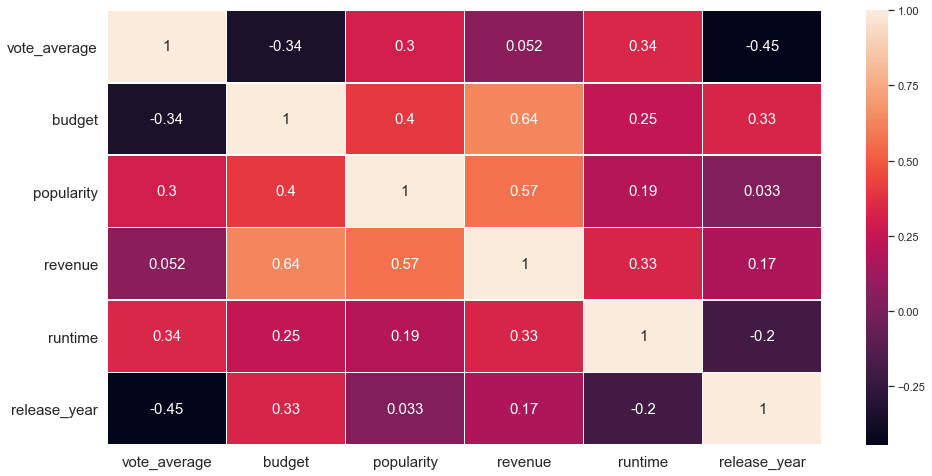

In [42]:
# correlation between numeric features
corr_meth = ['pearson', 'kendall', 'spearman']
    
def plot_corr(df,meth,filename):
    plt.subplots(figsize=(16, 8))
    sns.heatmap(df.corr(method = meth),annot=True,linewidths=.5,annot_kws={"fontsize":15})
    plt.yticks(rotation=0,fontsize=15)
    plt.xticks(rotation=0,fontsize=15)
    if saving:plt.savefig(filename,dpi=150)
    plt.show()

plot_corr(pred[["vote_average","budget","popularity","revenue","runtime","release_year"]],'pearson',filename="corrpearson.png")

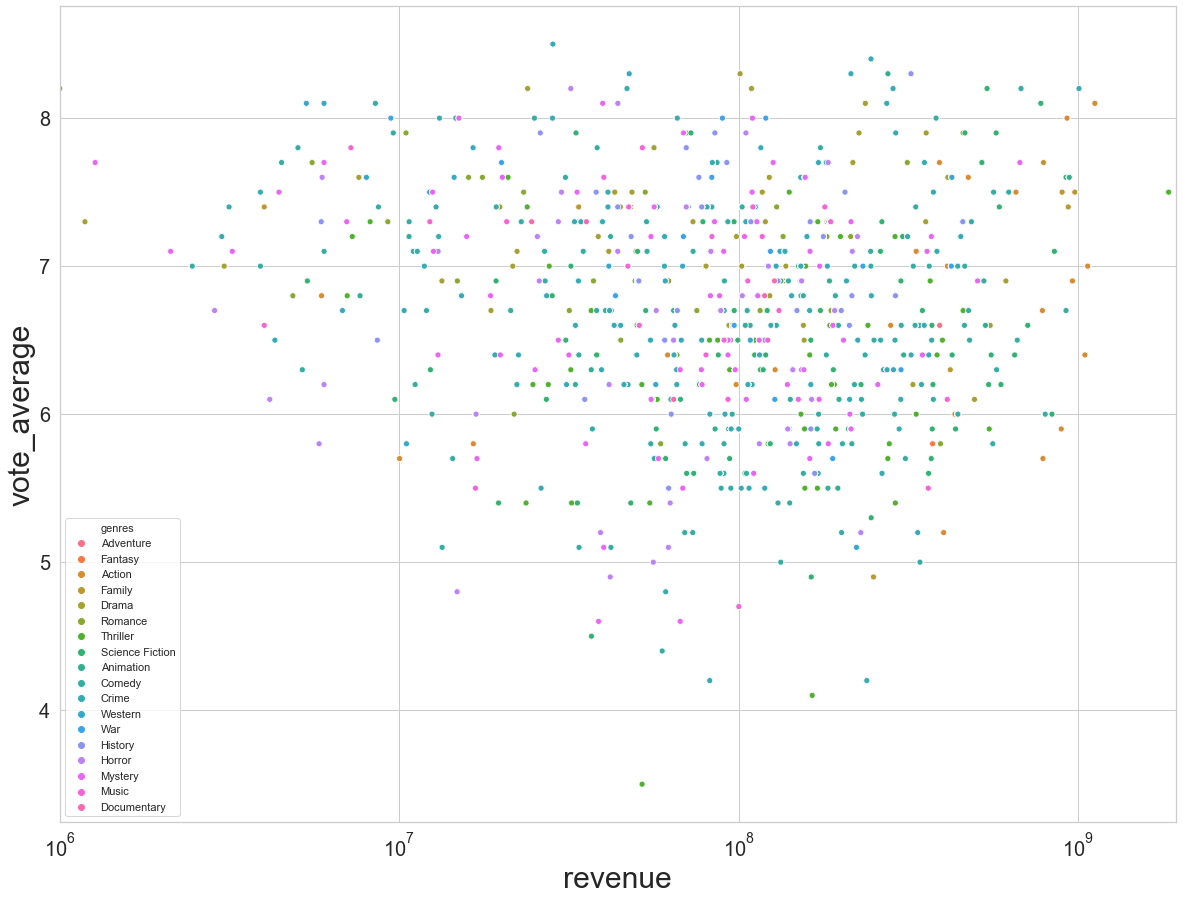

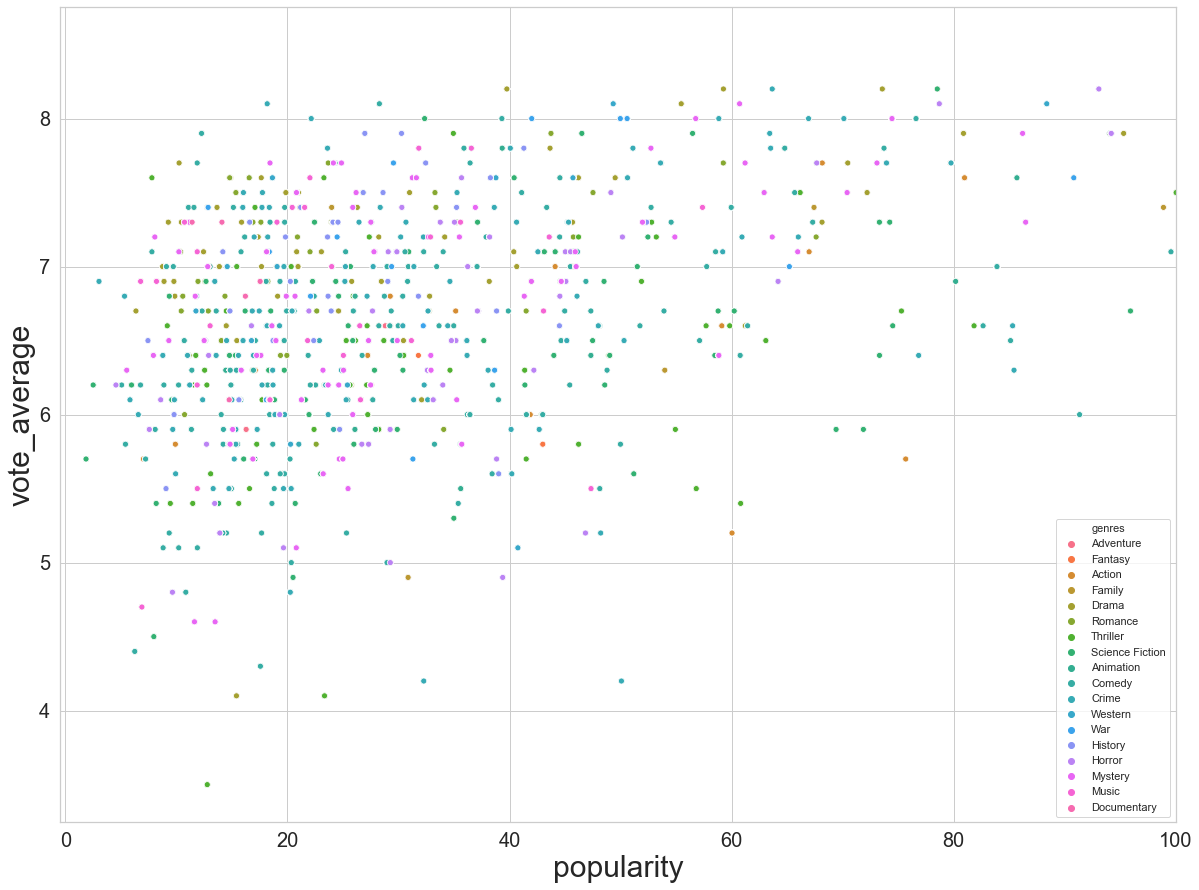

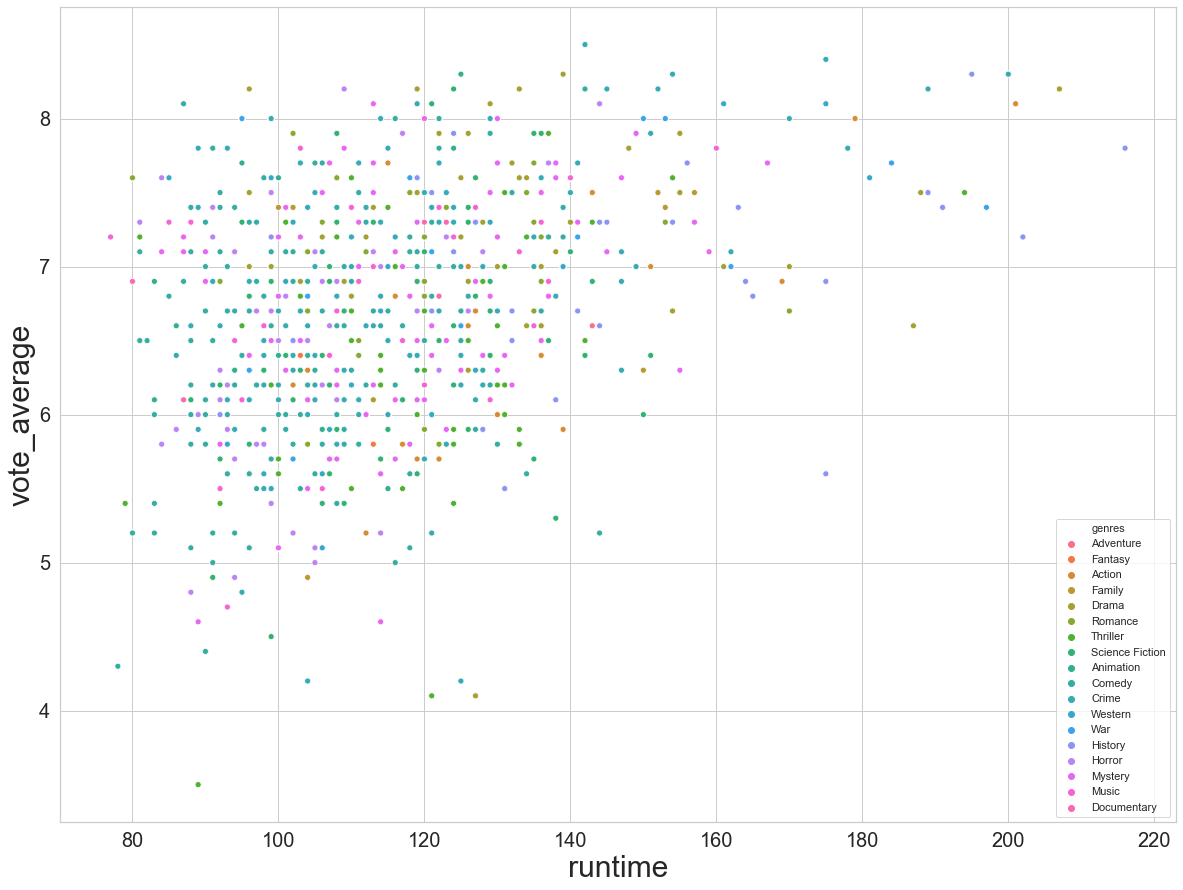

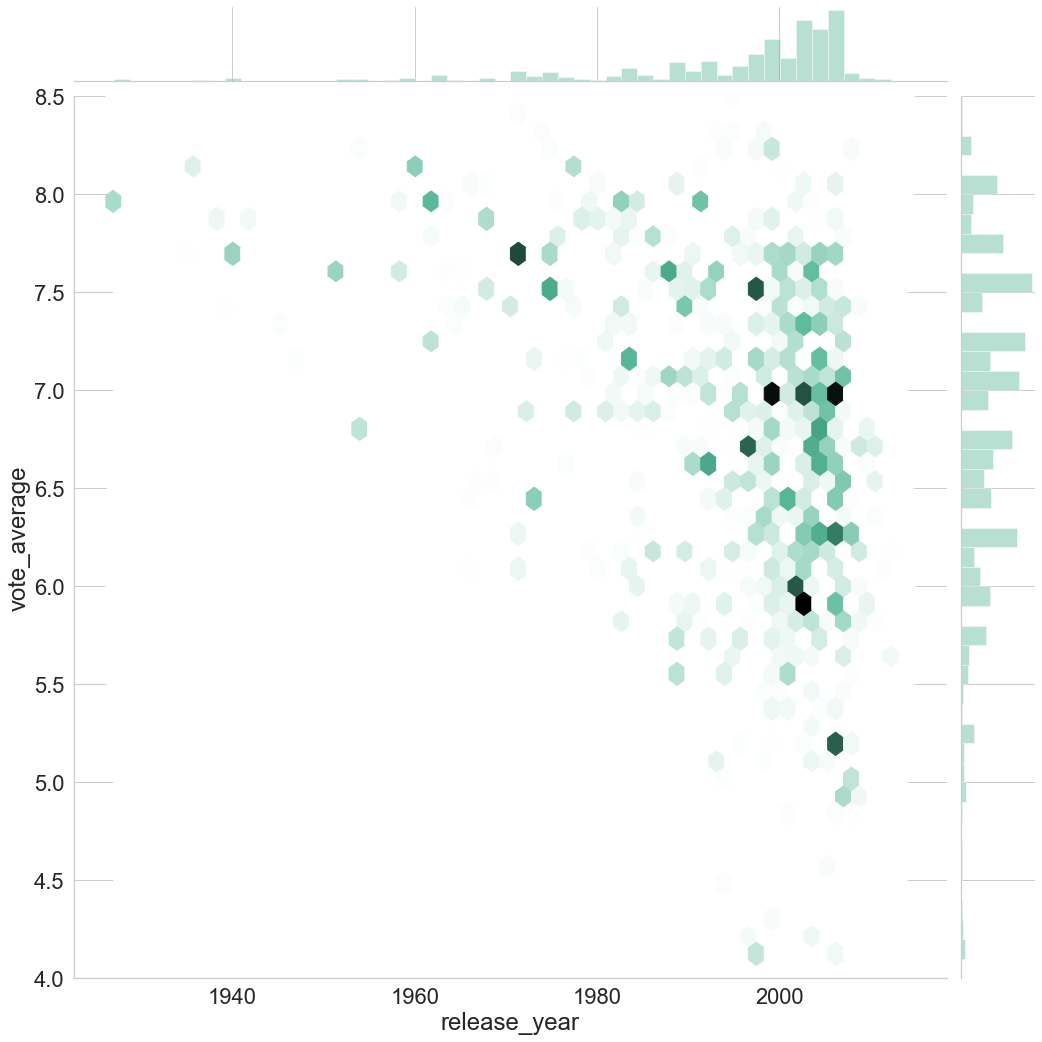

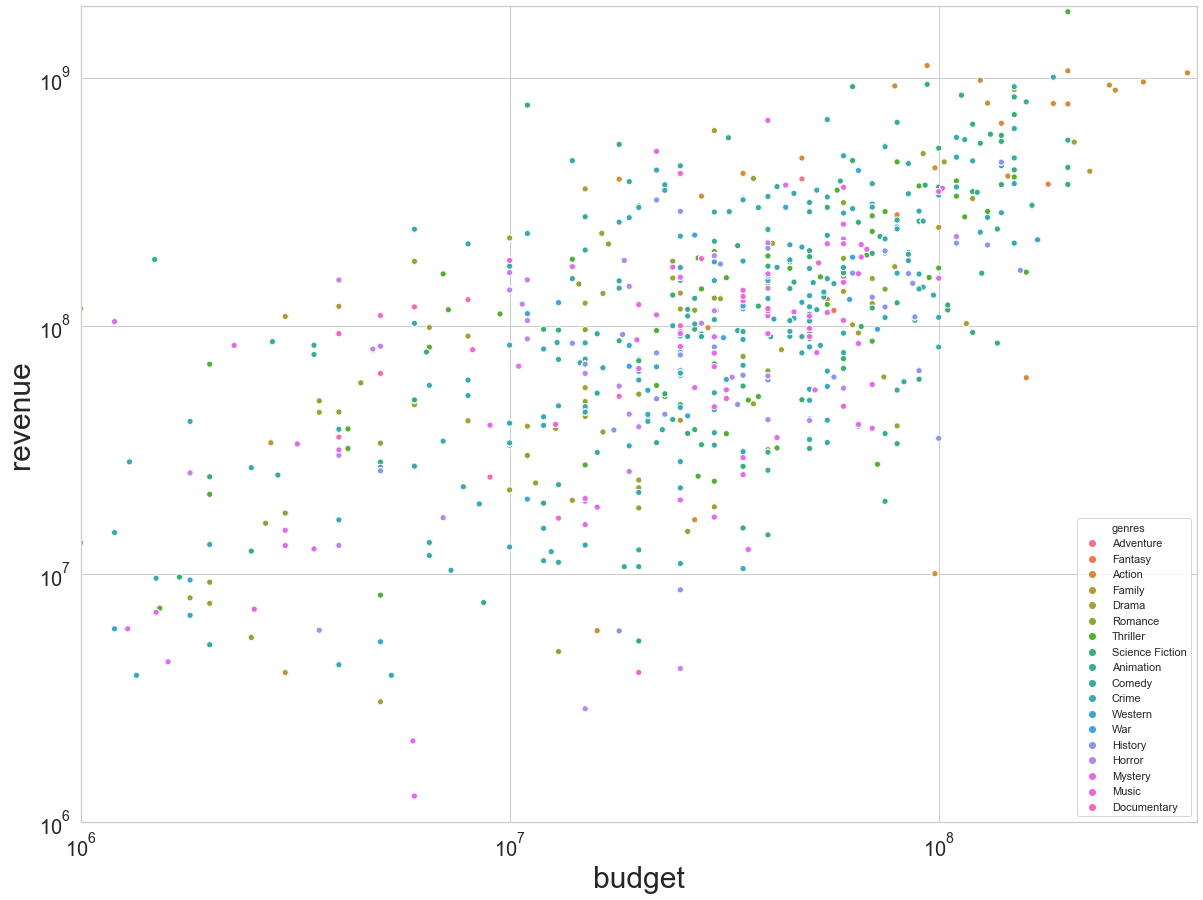

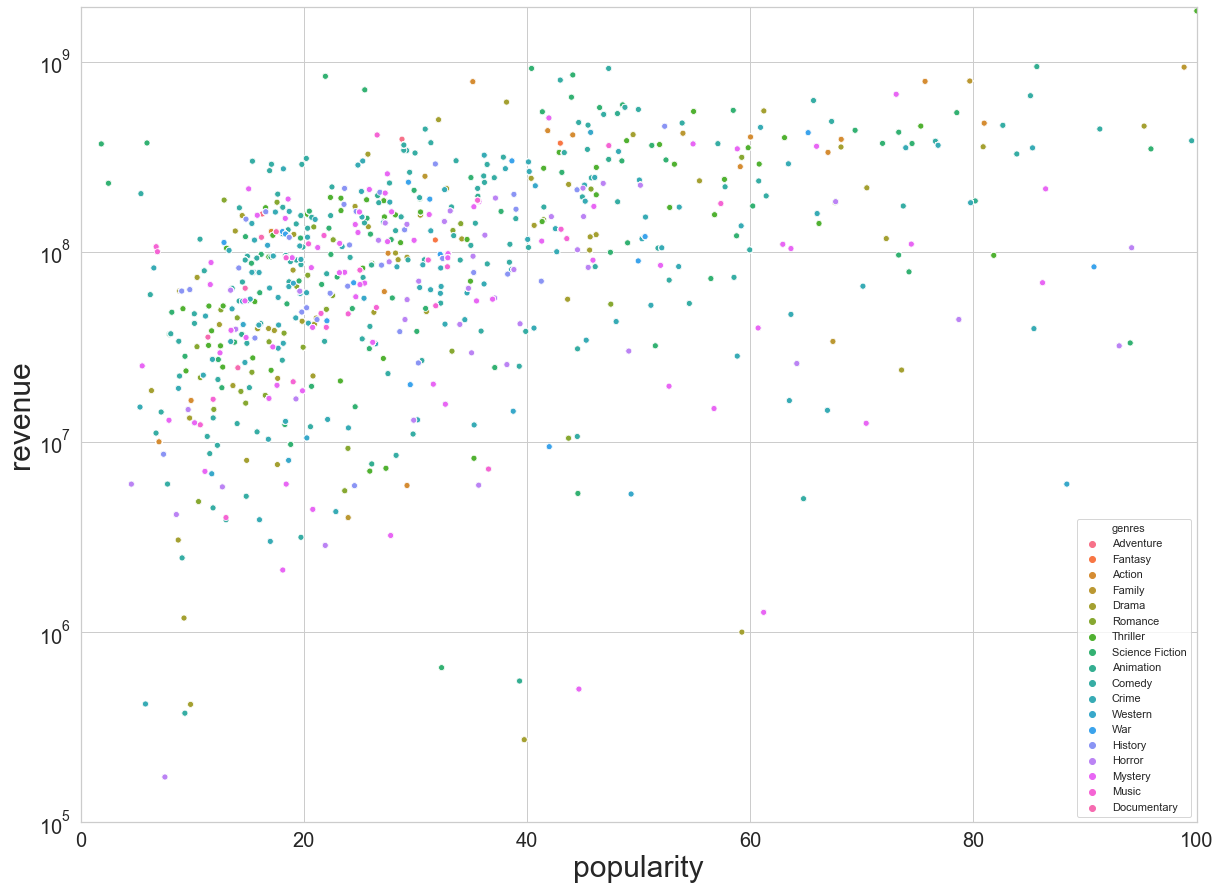

In [43]:
# see the scatter of features
def plotscatter(df,x,y,hue,filename,xlim=None,ylim=None,xscale=None,yscale=None):
    sns.set(style="whitegrid")
    df=df.replace(0,np.nan).copy()
    f,ax=plt.subplots(figsize=(20, 15))
    sns.scatterplot(data=expand_multi_feature(df,hue,"name"),x=x,y=y,hue=hue)
    plt.yticks(fontsize=20)
    plt.xticks(fontsize=20)
    plt.xlabel(x,fontsize=30)
    plt.ylabel(y,fontsize=30)
    if xlim:plt.xlim(xlim)
    if xscale:plt.xscale(xscale)
    if ylim:plt.ylim(ylim)
    if yscale:plt.yscale(yscale)
    if saving:plt.savefig(filename,bbox_inches="tight",dpi=150)
    plt.show()

def plotjoint(df,x,y,filename,xlim=None,ylim=None,xscale=None,yscale=None):
    sns.set(style=None,font_scale=2)
    grid=sns.jointplot(pred[x],pred[y],kind="hex",color="#4CB391",height=15,ratio=10,xlim=xlim,ylim=ylim)
    if saving:grid.savefig(filename)
        
    
plotscatter(pred,"revenue","vote_average","genres",xlim=1e6,xscale="log",filename="scatter_revenue_vote.png")
plotscatter(pred,"popularity","vote_average","genres",xlim=(-0.5,100),filename="scatter_popularity_vote.png")
plotscatter(pred,"runtime","vote_average","genres",filename="scatter_runtime_vote.png")
plotjoint(pred,"release_year","vote_average",filename="scatter_year_vote.png",ylim=(4,8.5))

plotscatter(pred,"budget","revenue","genres",xlim=1e6,ylim=1e6,xscale="log",yscale="log",filename="scatter_budget_revenue.png")
plotscatter(pred,"popularity","revenue","genres",xlim=(0,100),ylim=1e5,yscale="log",filename="scatter_popularity_revenue.png")